## DRENAR

In [1]:
pip install nmrglue


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Load data

#### Define data and experiment

In [3]:
import os
import nmrglue as ng
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.constants import pi
from scipy.constants import physical_constants
from scipy.optimize import curve_fit
import utils
from utils import gamma

In [4]:
# vars(utils)

In [5]:
# define data location
PREFIX=r"C:\Messdaten\TWC-SM\NMR Data\500 MHz\Lumineszenz"
LIB="31.07.2024"
EXPNAME="240731_3p2mm_13P-DRENAR_Mechanolumineszenz"

expno = '14'  # @param {type:"string"}
procno = '1'  # @param {type:"string"}

# define processing parameters
int_width = 100
number_of_peak=2
# define experiment paramters
spin_rate = 17  # in kHz

# define constants
mu_0 = physical_constants['vacuum mag. permeability'][0]
print(mu_0)
hbar = physical_constants['reduced Planck constant'][0]
gamma_S = gamma.P

# define a guess of the distance as initial value for fitting
r_guess = 0.4  # in nm


1.25663706212e-06


#### Read and process all spectra

In [6]:
# get a list of all processed spectra
# dir_exp = os.path.join(PREFIX, LIB, EXPNAME)
# dir_proc = os.path.join(PREFIX, LIB, EXPNAME, expno, 'pdata')
dir_exp = os.path.join(PREFIX, EXPNAME)
dir_proc = os.path.join(PREFIX, EXPNAME, expno, 'pdata')
procs = []
print(dir_proc)
for root, dirs, files in os.walk(dir_proc):
    for name in dirs:
        procs.append(name)

del procs[0]
num_of_procs = len(procs)
int_list = np.zeros(num_of_procs)



# read and process all spectra
first_spec = True
counter = 0
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
for procno in procs:
    
    path_proc = os.path.join(dir_proc, procno)
    dic,data = ng.bruker.read_pdata(path_proc)

    if first_spec:
        first_spec = False
        # define peak region
        pp_threshold = data.max()/2
        peaks = ng.peakpick.pick(data, pthres=pp_threshold, algorithm="downward")
        peak_center = peaks[number_of_peak]["X_AXIS"]# + peaks[1]["X_AXIS"])/2
        int_lb = int(peak_center - int_width/2)
        int_ub = int(peak_center + int_width/2)
        ax.plot(data.real)
        for n, peak in enumerate(peaks):
            height = data[int(peak["X_AXIS"])]
            ax.scatter(peak["X_AXIS"], height, marker="o", color="r", s=100, alpha=0.5)
            ax.text(peak["X_AXIS"], height+5e5, n+1, ha="center", va="center")

        intrng = data[int_lb:int_ub+1]
        intrng_scale = np.arange(0, data.shape[0], 1)[int_lb:int_ub+1]
        ax.plot(intrng_scale, intrng.cumsum()/100. + data.max(), 'g-')
        ax.plot(intrng_scale, [0]*len(intrng_scale), 'r-')
        ax.text(intrng_scale[0], 0.5*intrng.sum()/100. + data.max(), "integral", fontsize=8)

        # ax.hlines(pp_threshold, , linestyle="--", color="k")
        ax.set_ylim(top=data.max()*1.2)
        plt.show()

    intrng = data[int_lb:int_ub+1]
    intrng_scale = np.arange(0, data.shape[0], 1)[int_lb:int_ub+1]
    int_list[counter] = intrng.sum()
    counter = counter+1

C:\Messdaten\TWC-SM\NMR Data\500 MHz\Lumineszenz\240731_3p2mm_13P-DRENAR_Mechanolumineszenz\14\pdata


IndexError: list assignment index out of range

#### Calculate experimental DRENAR points

Maximum evolution time: 11.3 ms


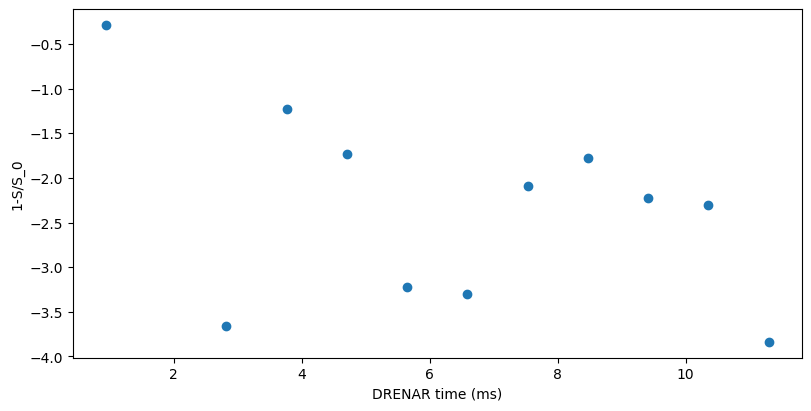

In [ ]:
int_list = int_list.reshape(2, int(num_of_procs/2))
# print(len(int_list))

diff_list = np.zeros(int_list.shape[1])
# print(len(diff_list))
drenar_list = np.zeros(int_list.shape[1])
for j in range(int_list.shape[1]):
    diff_list[j] = int_list[1, j] - int_list[0, j]
    drenar_list[j] = diff_list[j] / int_list[1, j]

# print(diff_list)
# print(drenar_list)
#print(int_list.shape[1])

# plot
# plt.plot(data)
# plt.savefig("./fig/plot.png")

# plot DRENAR points
d5 = 1 / spin_rate  # in ms
time_exp = np.zeros(int_list.shape[1])

for i in range(int_list.shape[1]):
     time_exp[i] = 16*(i+1)*d5

print("Maximum evolution time: {:.1f} ms".format(time_exp[-1]))

new_list=np.zeros((int_list.shape[1], 2))

for k in range(drenar_list.shape[0]):
    new_list[k][0]=time_exp[k]
    new_list[k][1]=drenar_list[k]

new_list = [row for row in new_list if row[1] <= 5]

x_coords = [row[0] for row in new_list]
y_coords = [row[1] for row in new_list]


fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
#ax.scatter(time_exp, drenar_list)
ax.scatter(x_coords, y_coords)
ax.set_xlabel('DRENAR time (ms)')
ax.set_ylabel('1-S/S_0')
plt.show()

In [ ]:
int_list.shape[1]

12

#### If needed, write data points to a file

In [ ]:
int_list1 = np.zeros(int_list.shape[1])
int_list2 = np.zeros(int_list.shape[1])
for j in range(int_list.shape[1]):
    int_list1[j] = int_list[0, j]
    int_list2[j] = int_list[1, j]

In [ ]:
#filename = os.path.join("./", "data", EXPNAME + "_" + expno + ".csv")
filename = os.path.join("./", EXPNAME + "_" + expno + ".csv")
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerow(time_exp)
    csvwriter.writerow(int_list1)
    csvwriter.writerow(int_list2)

#### Read data points from a file (not needed if previous cells are correctly run)

In [ ]:
# define experiment
EXPNAME = os.getenv("EXPNAME")
expno = '50'
filename = os.path.join("./", "data", EXPNAME + "_" + expno + ".csv")
with open(filename, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    time_exp = np.array(csvreader.__next__(), dtype="double")
    drenar_list = np.array(csvreader.__next__(), dtype="double")

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

#### Fit the DRENAR curve

In [ ]:
d_guess = mu_0 / (4*pi) * ((gamma_S**2) * hbar) / (2*pi) / (r_guess/10**9)**3 /1000  # in Hz
print('Dipolar coupling constant by guess = {:.3f} kHz'.format(d_guess))


# fit DRENAR curve with parabola function
max_number_of_points = 3
d5 = 1 / spin_rate  # in ms

new_drenar_list=np.zeros(max_number_of_points+1)
new_time_list= np.zeros(max_number_of_points+1)

for k in range(max_number_of_points):
    new_drenar_list[k+1] = drenar_list[k]
    new_time_list[k+1] = time_exp[k]

def drenar_calculator(x, b):
    result = (12/5)* b**2 * x**2
    return result


popt, pconv = curve_fit(drenar_calculator, new_time_list, new_drenar_list, p0=d_guess, bounds=(0,10))
perr = np.sqrt(np.diag(pconv))  # standard deviation
print(perr)

print('Dipolar coupling constant by fitting = {:.3f} kHz'.format(popt[0]))
print('Standard deviation of dipolar coupling constant by fitting = {:.4f} kHz'.format(perr[0]))

r_opt = (mu_0 / (4*pi) * ((gamma_S**2) * hbar) / (2*pi) / popt[0] /1000)**(1/3) * 10**9  # in nm
print('Fitted r = {:.3f} nm'.format(r_opt))

# plot
time_axis = np.linspace(0,time_exp[-1],100)
drenar_opt = drenar_calculator(time_axis, popt[0])
drenar_guess = drenar_calculator(time_axis, d_IS_guess)

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
ax.scatter(time_exp, drenar_list)
ax.plot(time_axis, drenar_opt)
ax.plot(time_axis, drenar_guess)
ax.set_xlabel('DRENAR time (ms)')
ax.set_ylabel('1-S/S_0')
ax.set_xlim(left=0)
ax.set_ylim(top=2,bottom=-0.5)
ax.text(0.75*time_exp.max(),0.1*drenar_opt.max(),'Fitted r = {:.3f} nm'.format(r_opt))
plt.show()


Dipolar coupling constant by guess = 0.308 kHz
[0.57057844]
Dipolar coupling constant by fitting = 0.441 kHz
Standard deviation of dipolar coupling constant by fitting = 0.5706 kHz
Fitted r = 0.355 nm


NameError: name 'd_IS_guess' is not defined

Author: Yufei Wu  
Last changed: 2024-08-04  
Email: yufei.wu@itmc.rwth-aachen.de